<a href="https://colab.research.google.com/github/changw121/Best-websites-a-programmer-should-visit/blob/master/pyG%E5%B0%8F%E5%AE%9E%E6%88%9801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pyG中的数据处理、数据集、加载器和转换
使用GCN层
在Cora引文数据集上实验

In [ ]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=00e3bade2d43a64121d6ac36f3d17eb11528646747a9cd4acea7fa35db30328e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 108.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 68.9 MB/s eta 0:00:00


# Cora数据集介绍

该数据集**共2708个样本点**，每个样本点都是一篇科学论文，**所有样本点被分为7个类别**，类别分别是1）基于案例；2）遗传算法；3）神经网络；4）概率方法；5）强化学习；6）规则学习；7）理论。

每篇论文都由一个**1433维**的词向量表示，所以，**每个样本点具有1433个特征**。词向量的每个元素都对应一个词，且该元素只有0或1两种取值。取0表示该元素对应的词不在论文中，取1表示在论文中。所有的词来源于一个具有1433个词的字典。？？？

每篇论文都至少引用了一篇其他论文，或者被其他论文引用，也就是样本点之间存在联系，没有任何一个样本点与其他样本点完全没联系。如果将样本点看作图中的点，则**这是一个连通的图，不存在孤立点**。

数据集主要文件有两个：cora.cites, cora.content。其中，cora.content包含了2708个样本的具体信息，每行代表一个论文样本，格式为
<论文id>  <由01组成的1433维特征>  <论文类别（label）>？？？

总的来说，如果将论文当作“图”的节点，则引用关系则为“图”的边，论文节点信息和引用关系共同构成了图数据。

本次实验，我们将利用这些信息，**对论文所属的类别进行预测**，完成关于论文类别的分类任务。

In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [ ]:
dataset

Cora()

In [ ]:
len(dataset) # 1表示只包含一个graph

1

In [ ]:
dataset[0].is_undirected() # 第一个图是无向图

True

In [ ]:
dataset[0] # 通过索引的方式来访问数据集中的数据：第一个图包含有2708个结点，每个结点特征维度为1433，10556/2=5278条无向边，train_mask是训练集的mask向量，标识哪些节点属于训练集。val_mask验证集。test_mask是测试集。y是节点的标签维度。

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
dataset.num_node_features # 节点特征维度为1433

1433

In [ ]:
dataset.num_classes #节点类别个数为7

7

In [ ]:
dataset[0].y.unique() #一共多少种类别

tensor([0, 1, 2, 3, 4, 5, 6])

# node-level prediction 节点分类任务
1. 模型搭建（实现两层GCN）

```from torch_geometric.nn import GCNConv```

模型参数：


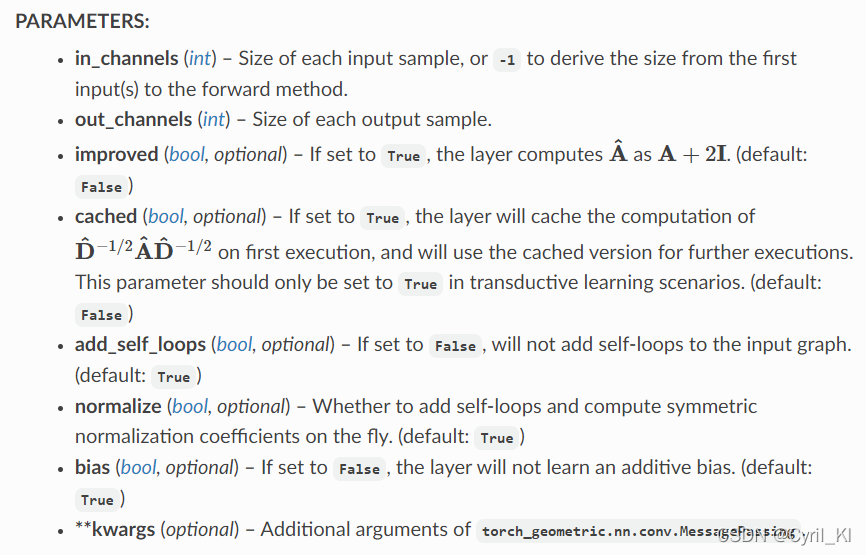

**in_channels**：输入通道，比如节点分类中表示每个节点的特征数。

**out_channels**：输出通道，最后一层GCNConv的输出通道为节点类别数（节点分类）。

improved：如果为True表示自环增加，也就是原始邻接矩阵加上2I而不是I，默认为False。

cached：如果为True，GCNConv在第一次对邻接矩阵进行归一化时会进行缓存，以后将不再重复计算。

add_self_loops：如果为False不再强制添加自环，默认为True。

normalize：默认为True，表示对邻接矩阵进行归一化。

bias：默认添加偏置。


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module): # 继承Module
    def __init__(self): # 定义所有网络层。self含义：一般情况下，一个函数的变量不可以床底给另外的函数，使用self后可以将这个变量传递给后面的函数
        super().__init__() # 继承父类
        self.conv1 = GCNConv(dataset.num_node_features, 16) # 输入维度是每个节点的特征数目 # 16是中间隐藏层的维度
        self.conv2 = GCNConv(16, dataset.num_classes) # 输出的是类别数

    def forward(self, data): # 前向函数，输入是data
        # 加载结点特征和邻接关系
        x, edge_index = data.x, data.edge_index
        # 传入卷积层
        x = self.conv1(x, edge_index)
        x = F.relu(x) # 激活函数
        x = F.dropout(x, training=self.training) # dropout层，防止过拟合
        x = self.conv2(x, edge_index) # 第二层卷积层

        return F.log_softmax(x, dim=1) # 将经过两层卷积得到的特征输入log_softmax函数得到概率分布（对行做归一化）

2. 训练模型

In [ ]:
from torch.optim import optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU
model = GCN().to(device) # 将构建的模型分配到device上
data = dataset[0].to(device) # 将数据分配到device上
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # 定义优化函数（model.parameters()是待优化的参数，lr是学习率，weight_decay是权重衰减）

In [ ]:
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
model.train()
for epoch in range(100): # 该模型训练100个epoch，loss函数使用null_loss
    optimizer.zero_grad() # 梯度设为零
    out = model(data) # 利用前向传播计算出模型输出，out即为最终得到的每个节点的7个概率值
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # 在实际训练中，我们只需要计算出训练集的损失，所以损失函数这样写
    loss.backward() # 计算梯度，反向更新
    optimizer.step() # 一步优化，更新参数

    if epoch%10 == 0:
      print(f'epoch:{epoch}, loss:{loss}, acc:{accuracy_score(data.y[data.val_mask].cpu(), out.argmax(dim=1)[data.val_mask].cpu())}')

epoch:0, loss:1.9568045139312744, acc:0.186
epoch:10, loss:0.9536699652671814, acc:0.542
epoch:20, loss:0.3142772614955902, acc:0.718
epoch:30, loss:0.11366307735443115, acc:0.716
epoch:40, loss:0.06791705638170242, acc:0.732
epoch:50, loss:0.05593932047486305, acc:0.72
epoch:60, loss:0.04146436229348183, acc:0.744
epoch:70, loss:0.04927568882703781, acc:0.76
epoch:80, loss:0.033658694475889206, acc:0.752
epoch:90, loss:0.04601650685071945, acc:0.72


3. 在测试集结点上评估模型

In [ ]:
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
model.eval() # 评估模型
pred = model(data).argmax(dim=1) # model(data)计算出模型对所有结点的7个预测值，每一个取其最大值，得到最终的预测值
acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu()) # 计算预测精度
prec = precision_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
rec = recall_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(),average="macro")
print("The accuracy is: ",acc)
print("The precision is: ",prec)
print("The recall is: ",rec)
print("The f1 is: ",f1)

The accuracy is:  0.807
The precision is:  0.7927584796180814
The recall is:  0.8207062754455122
The f1 is:  0.801821797542347


# 补充知识点

1. 数据存放目录：

如果加载数据出现问题，可以自行下载数据并创建文件夹，将data中有关cora的数据放在下图所示的目录中：

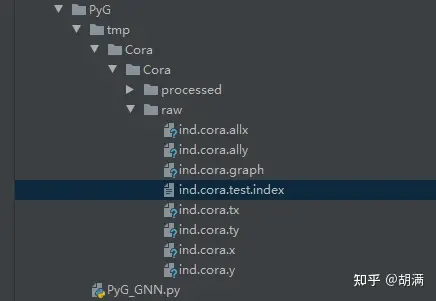

2. model.train()和model.eval()的含义：

这两个函数分别定义模型的训练模式和测试模式，主要对Dropout层和BatchNorm产生影响，主要影响如下:

Dropout: 训练过程中，为防止模型过拟合，增加其泛化性，会随机屏蔽掉一些神经元，相当于输入每次经过不同的神经元，最终得到不同的模型。测试模式时，所有神经元共同作用，类似于boosting。

BatchNorm: 训练过程中，模型每次处理一个minibatch数据，BN层根据一个minibatch来计算mean和std后做归一化处理。测试时，BN层会利用训练时得到的参数来处理测试数据。如果不设置model.eval()，输入单个数据，模型会报错。

3. ReLu()函数
在多层神经网络中，上层节点的输出和下层节点的输入之间具有一个函数关系，这个函数称为激活函数。

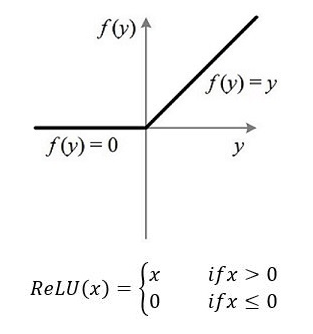




引入激活函数是为了增加神经网络模型的非线性。没有激活函数的每层都相当于矩阵相乘。就算你叠加了若干层之后，无非还是个矩阵相乘罢了。

如果不用激励函数，每一层输出都是上层输入的线性函数，无论神经网络有多少层，输出都是输入的线性组合，这种情况就是最原始的感知机（Perceptron）。

如果使用的话，激活函数给神经元引入了非线性因素，使得神经网络可以任意逼近任何非线性函数，这样神经网络就可以应用到众多的非线性模型中。

ReLU 能够在x>0时保持梯度不衰减，从而缓解梯度消失问题。

4. dropout()

dropout出现的原因：Dropout可以比较有效的缓解过拟合的发生，在一定程度上达到正则化的效果。过拟合具体表现在：模型在训练数据上损失函数较小，预测准确率较高；但是在测试数据上损失函数比较大，预测准确率较低。

Dropout说的简单一点就是：我们在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征，如图1所示。

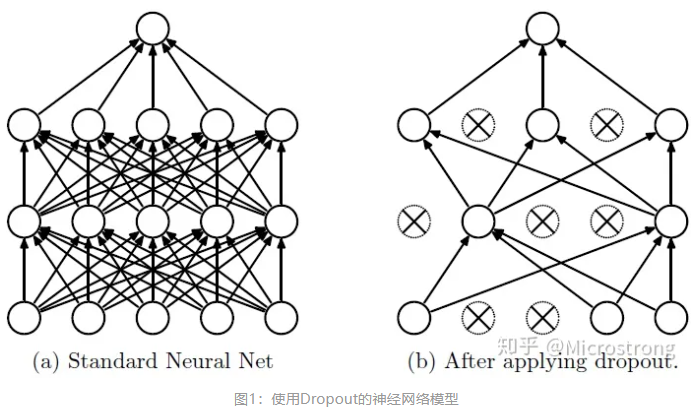





dropout的具体流程：

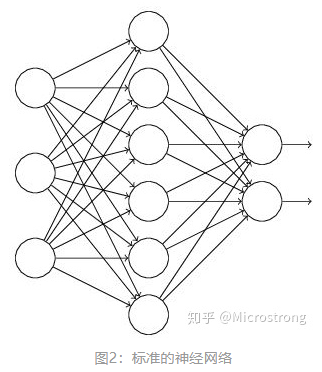






输入是x输出是y，正常的流程是：我们首先把x通过网络前向传播，然后把误差反向传播以决定如何更新参数让网络进行学习。使用Dropout之后，过程变成如下：

（1）首先随机（临时）删掉网络中一半的隐藏神经元，输入输出神经元保持不变（图3中虚线为部分临时被删除的神经元）

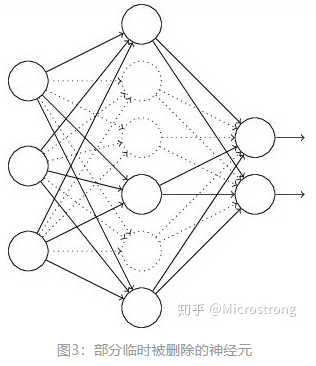



（2） 然后把输入x通过修改后的网络前向传播，然后把得到的损失结果通过修改的网络反向传播。一小批训练样本执行完这个过程后，在没有被删除的神经元上按照随机梯度下降法更新对应的参数（w，b）。

（3）然后继续重复这一过程：

恢复被删掉的神经元（此时被删除的神经元保持原样，而没有被删除的神经元已经有所更新）

从隐藏层神经元中随机选择一个一半大小的子集临时删除掉（备份被删除神经元的参数）。

对一小批训练样本，先前向传播然后反向传播损失并根据随机梯度下降法更新参数（w，b） （没有被删除的那一部分参数得到更新，删除的神经元参数保持被删除前的结果）。

不断重复这一过程。

Dropout的具体工作流程上面已经详细的介绍过了，但是具体怎么让某些神经元以一定的概率停止工作（就是被删除掉）？代码层面如何实现呢？

代码层面实现让某个神经元以概率p停止工作，其实就是让它的激活函数值以概率p变为0。比如我们某一层网络神经元的个数为1000个，其激活函数输出值为y1、y2、y3、......、y1000，我们dropout比率选择0.4，那么这一层神经元经过dropout后，1000个神经元中会有大约400个的值被置为0。

5. log_softmax()

softmax()

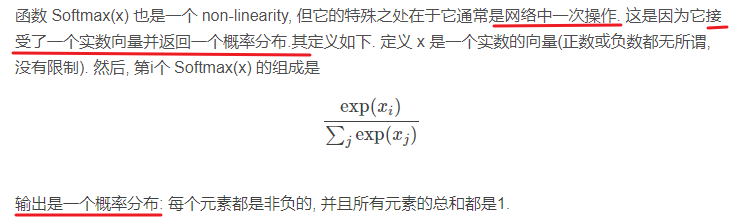


F.softmax作用:按照行或者列来做归一化的

F.softmax函数语言格式:
```# 0是对列做归一化，1是对行做归一化```
```F.softmax(x,dim=1) 或者 F.softmax(x,dim=0)```

F.log_softmax()作用：在softmax的结果上再做多一次log运算

F.log_softmax函数语言格式：
```F.log_softmax(x,dim=1) 或者 F.log_softmax(x,dim=0)```

x指的是输入矩阵；dim：指的是归一化的方式，如果为0是对列做归一化，1是对行做归一化。



In [2]:
# 测试代码
import torch
import torch.nn.functional as F
logits = torch.rand(2,2)
pred = F.softmax(logits, dim=1)
pred1 = F.log_softmax(logits, dim=1)
print(logits)
print(pred)
print(pred1)

tensor([[0.9225, 0.0203],
        [0.5667, 0.9902]])
tensor([[0.7114, 0.2886],
        [0.3957, 0.6043]])
tensor([[-0.3405, -1.2427],
        [-0.9272, -0.5036]])


6. ```device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU```

这个device的用处是作为Tensor或者Model被分配到的位置。因此，在构建device对象后，紧跟的代码往往是：
```data = data.to(device)```

```model = Model(...).to(device)```

表示将构建的张量或者模型分配到相应的设备上。




7. ```optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)```

optimzier优化器的作用：优化器就是需要根据网络反向传播的梯度信息来更新网络的参数，以起到降低loss函数计算值的作用。

在创建优化器对象的时候，要**传入网络模型的参数**，并设置**学习率**等优化方法的参数。然后使用函数**zero_grad将梯度置为零**。接着调用函数**backward来进行反向传播计算梯度**。最后使用优化器的**step函数来更新参数**。




optimizer.step()：会更新所有的参数。一旦梯度被如backward()之类的函数计算好后，我们就可以调用这个函数。

8. ```loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])```


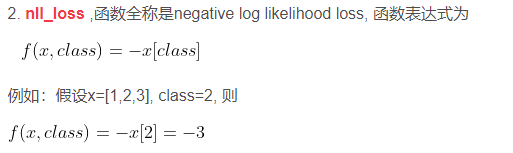


nll_loss()是一个损失函数，它计算一个张量的负对数似然损失

```torch.nn.functional.nll_loss(input, target, weight=None,size_average=None,                       ignore_index=-100, reduce=None, reduction='mean')```

input期望是一个对数的概率，所以之前的概率最好是对数形式，比如使用torch.nn.functional.log_softmax求预测的概率。

reduction='mean'，计算的是平均loss。

9. ```loss.backward()```

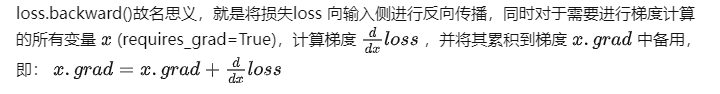




10. argmax()

argmax是一个NumPy函数，用于返回数组中最大值的索引。

In [1]:
import numpy as np
# 一维
a = np.array([3, 2, 1, 2, 3, 0])
print(np.argmax(a))  # 输出 0

0


In [2]:
import torch
a=torch.tensor([
              [
                  [1, 5, 5, 2],
                  [9, -6, 2, 8],
                  [-3, 7, -9, 1]
              ],

              [
                  [-1, 7, -5, 2],
                  [9, 6, 2, 8],
                  [3, 7, 9, 1]
              ]])
b=torch.argmax(a,dim=1)
print(a)
print(a.shape)
print(b)

tensor([[[ 1,  5,  5,  2],
         [ 9, -6,  2,  8],
         [-3,  7, -9,  1]],

        [[-1,  7, -5,  2],
         [ 9,  6,  2,  8],
         [ 3,  7,  9,  1]]])
torch.Size([2, 3, 4])
tensor([[1, 2, 0, 1],
        [1, 0, 2, 1]])


这个例子，tensor(2, 3, 4)，因为是dim=1，即将第二维度去掉，变成tensor(2, 4)，将每一个3x4数组，变成1x4数组。

[1, 5, 5, 2],

[9, -6, 2, 8],

[-3, 7, -9, 1]

如上所示的3×4矩阵，取每一列的最大值对应的下标，a[0]中第一列的最大值的行标为1， 第二列的最大值的行标为2，第三列的最大值行标为0，第4列的最大值行标为1，所以最后输出[1, 2, 0, 1]，取每一列的最大

11. ```accuracy_score准确率```

表示分类正确的样本占总样本个数的比例。
只有当数据集各个类别的样本比例比较均衡时，Accuracy这个指标才是一个比较好的衡量标准。

分类正确的样本有两部分组成，分别是预测为正且真实为正的情况，即TP；还有是预测为负且真实也为负的情况，即TN。总样本个数即为TP, FP, TN, FN之和。

```sklearn.metrics.accuracy_score(y_true,                            y_pred,                                normalize=True,                           sample_weight=None                         )```

normalize：如果为False，则返回正确分类的样本数。否则，返回正确分类的样本的分数。



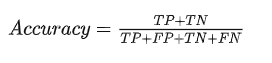

In [10]:
from sklearn.metrics import accuracy_score
target=np.array([1,1,1,1,1])
pred=np.array([2,2,1,1,1])
accuracy_score(target, pred) # 输出0.6(预测了5个，对了3个)

0.6

In [6]:
accuracy_score(y_true, y_pred, normalize=False)

2

12. ```precision_score精确率```

precision_score与accuracy的意思类似，但不完全一样，它是从pred的角度考虑，意思是我虽然预测了这么多个，但有几个预测对了？占比多少？这就是precision

当反例被错误预测成正例（FP）的代价很高时，适合用精确率。比如在垃圾在垃圾邮件检测中，假正例意味着非垃圾邮件（实际为负）被错误的预测为垃圾邮件（预测为正）。如果一个垃圾邮件监测系统的查准率不高导致很多非垃圾邮件被归到垃圾邮箱里去，那么邮箱用户可能会丢失或者漏看一些很重要的邮件

```sklearn.metrics.precision_score(y_true,y_pred, labels=None,                         pos_label=1,                                 average='binary',                                 sample_weight=None,                                zero_division='warn'                               )```


    average:计算类型string,[None,‘binary’ (default),‘micro’,‘macro’,‘samples’,‘weighted’]average参数定义了该指标的计算方法，二分类时average参数默认是binary，多分类时，可选参数有micro、macro、weighted和samples。
    micro统计全局TP和FP来计算

    macro计算每个标签的未加权均值（不考虑不平衡）

    weighted计算每个标签等等加权均值（考虑不平衡）

    samples计算每个实例找出其均值

    None返回每类的精确度

    sample_weight : 样本权重

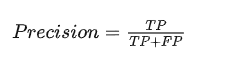

In [13]:
precision_score(target,pred) # 输出1

1.0

```precision_score(target,pred)```等价于```precision_score(target,pred,average='binary',pos_label=1)```

average='binary'表示pred当中(最多)只有两种标签(此处是1,2),pos_label=1表示最后输出的结果是针对类别值"1"的计算结果。

如果改成pos_label=2：

In [14]:
precision_score(target,pred,average='binary',pos_label=2)

0.0

则表示计算结果是针对类别为"2"的统计结果，结果为0.0（因为pred中有两个2，但都预测错了，所以为0）。

pos_label这个参数只有average='binary'时管用，若pred中出现3种及以上类别的标签，则pos_label参数即使设置了也会被忽略。

average参数的作用，当pred当中有3种或以上类别时，average的值只能取[None, 'micro', 'macro', 'weighted']当中的一种。

其中，有趣的是，当average='micro'时，precision_score(target,pred,average='micro')等价于accuracy的算法，就是看预测对的标签总个数，再除以pred的大小。

当average='macro'时，会计算每个种类标签的precision_score，再取平均(不考虑各个类别的样本分布差异)。例如:

In [15]:
target=np.array([1,1,2,3,3])
pred=np.array([2,2,1,3,4])
precision_score(target,pred,average='macro')

0.25

结果为0.25,怎么算出来的0.25？

首先确定，pred中一共是4个类别（1,2,3,4），预测对的只有pred[3]

类别1的precision=0/1（pred中只有1个标签1，预测对了0个）结果为0

类别2的precision=0/2（pred中有2个标签2，预测对了0个），结果为0

类别3的precision=1/1（pred中有1个标签3，预测对了1个），结果为1

类别4的precision=0/1（pred中有1个标签4，预测对了0个），结果为0

再取平均(不考虑类别的分布差异)：（0+0+1+0）/4=0.25。

Macro另外一个需要注意的地方在于，它在做平均的时候，它认为的类别数不是看target有多少个类别,也不是看pred有多少个类别，而是两者取并集，作为总的类别数。

13. 召回率recall

表示预测结果为正样本中实际正样本数量占全样本中正样本的比例。

当正例被错误的预测为反例（FN）产生的代价很高时，适合用召回率。

比如说在银行的欺诈检测或医院的病患者检测中，如果将欺诈性交易（实际为正）预测为非欺诈性交易（预测为负），则可能会给银行带来非常严重的损失。再比如以最近的新冠疫情为例，如果一个患病者（实际为正）经过试剂检测被预测为没有患病（预测为负），这样的假反例或者说假阴性产生的风险就非常大。

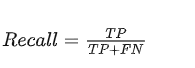

14. f1_score

F1 score是精确率和召回率的一个加权平均。

Precision体现了模型对负样本的区分能力，Precision越高，模型对负样本的区分能力越强；Recall体现了模型对正样本的识别能力，Recall越高，模型对正样本的识别能力越强。F1 score是两者的综合，F1 score越高，说明模型越稳健。


总结：当FP和FN造成的代价差不多的时候，可以直接用Accuracy。但是当FP和FN产生的代价差别很大的时候，可以考虑更好的度量方式，比如Precision, Recall和F1 score。

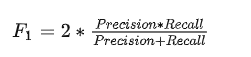

5. 前向传播

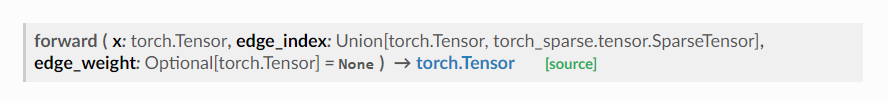

GCNConv中需要输入的是节点特征矩阵x和邻接关系edge_index，还有一个可选项edge_weight。

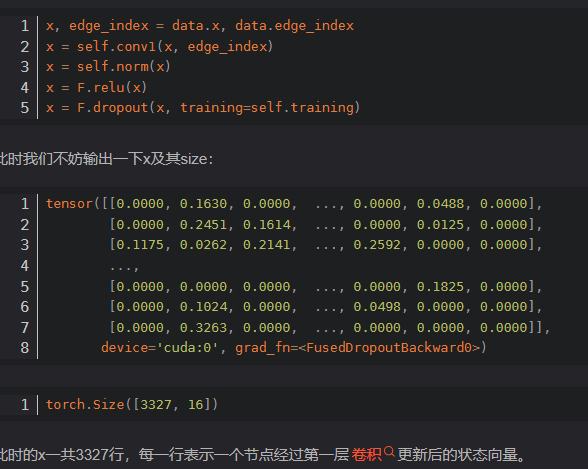

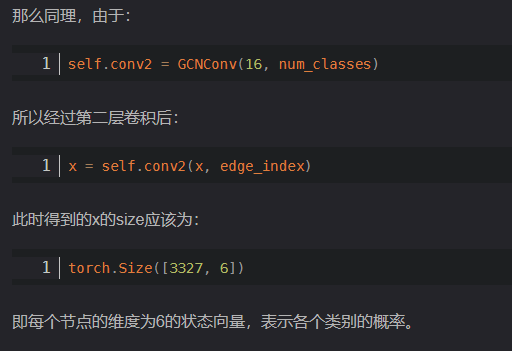

注：citeseer数据集的Nodes的数量，论文中给的是3,327，官网数据集上的是3,312。后来弄明白图中的节点数量是3,327，但是有15个没有特征向量，所以是3,312。

5. 反向传播

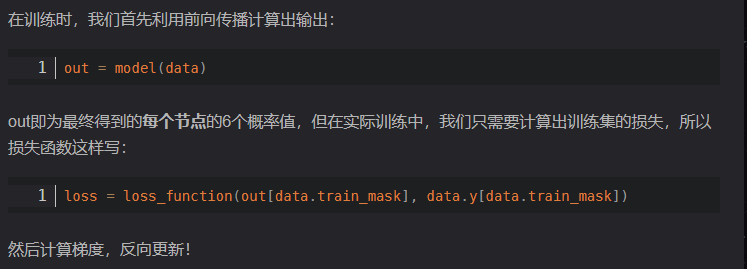


6.